## <center>Lux ABM<center>

This is an implementation of the ABM model proposed by Alfarano and Lux (2007).

The basic dynamics of the model are described by the following ODE:

$$
\begin{equation}
\frac{dp}{dt} = \beta \ [ N_F T_F (p_f - p) + N_C T_c x ] \ p, \qquad x = \frac{N_o - N_p}{N_C}
\end{equation}
$$

where $p$ is the market price of the stock, $p_f$ is the intrinsic value of the stock, $N_F$ is the number of fundamentalist traders, and $N_C$ is the number of noise traders. $N_F$ and $N_C$ are chosen beforehand and are fixed throughout the simulation.

$N_o$ is the number of noise traders who are optimists and $N_p$ is the number of noise traders who are pessimists (where $N_o + N_p = N_c$). $N_o$ and $N_p$ are dynamic and change throughout the simulation (described below).

$\beta$, $T_F$, and $T_C$ are essentially parameters to tune the model.

Some intuition about the ODE can be seen by rewriting it as follows:

$$
\frac{dp}{dt} = p \ [\beta N_F T_F] (p_f - p) + p \ [\beta N_C T_c] \ x
$$

Note that all values in the brackets are constants. The first expression on the right is just an exponential with a mean reverting term added to it. In words, the model pulls the price back to its fundamental value when it diverges too far. The second expression on the right is also an exponential form, but has noise $x$ added to it. Note that this noise has attractors at -1 and 1, so it can pull the value of the stock above or below the intrinsic value for long periods of time during the simulation.

The value of $p_f$ is constant in the paper, but the intrinsic value drives the valuation of a stock over time, so I've made this an exponential function in the implementation below:
$$
\frac{dp_f}{dt} = \mu p
$$

This allows the market to grow over time like a real market.

The simulation initially starts by randomly designating each noise trader an optimist or pessimist. For each timestep, each optimist has a probability $p_o$ of switching to a pessimist and each pessimist has a probability $p_p$ of switching to an optimist, where the switches are Bernoulli and are assigned the following probabilities:
$$
p_o = \nu \Delta t \frac{N_A}{N}
$$
$$
p_p = \nu \Delta t \frac{N_B}{N}
$$

where $\Delta t$ is the simulation timestep.

Set use_pycx to True for an interactive simulation (you'll need to expend the size of the dialog that pops up to see all the plots). Each tiny square in the bar on the top represents a trader (orange for optimist and gray for pessimist). The second bar just aggregates the results to get a quick view of whether the market overall is optimistic or pessimistic. The first time series plots optimists and pessimists. The second plots the fundamental (intrinsic) value and the simulated market price. The third plots the returns.

In [ ]:
use_pycx = False

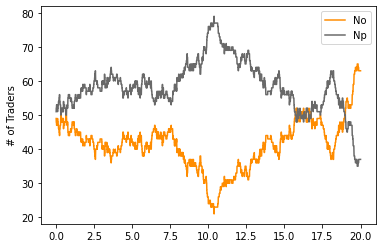

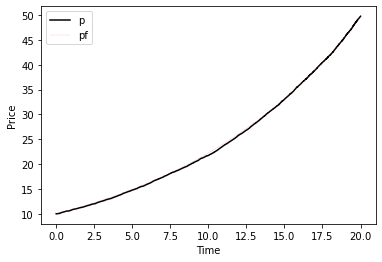

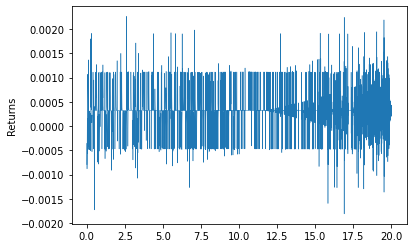

In [34]:
from pylab import *
from matplotlib import gridspec

T = 20. # number of time steps in simulation
Dt = 1./252  # 252 trading days in a year

N = 100 # number of agents

# Two types of agent:
#
# Fundamentalist traders
# Behavior: buy (or sell) a fixed amount of stocks Tf when 
#  the price is below (or above) a certain, set fundamental value price pf.
Nf = N # fundamentalist traders

# Noise traders
# Behavior: buying and selling behavior is driven by herd instincts.
#  Depending on expectation of future price movement a noise trader will
#  be either an optimist or pessamist.
Nc = N # noise traders

b = 0.1 # the speed of price adjustment.

Tf = 1 # a fundamentalist trader's sensativity to deviations between fundamental price and market price.
Tc = 1 # fixed transaction volume of a single noise trader.

# Parameter for the rate of contagion.
# Change this and the pattern of traders switching between 
# optimist and pessimist will change. In turn, so will the price fluctuations.
# Constraint: 0.5 * nu * Dt * N <= 1.
nu = .003/Dt 

mu = 0.08   # mean return


def initialize():
    global p, pf, No, Np, x, t, pvec, pfvec, Novec, Npvec, xvec, traders, tvec    
    
    pf = 10.0
    p = pf
   
    # Initialize by randomly generating N agents.
    # Each agent is assigned a 0 or 1, which indicates whether the agent
    # is a pessamist or optimist.
    traders = zeros([1, N])
    for i in range(N):
        traders[0, i] = randint(0, 2) # Each trader assigned a value 0 or 1

    No = len(traders[0, traders[0,:] > 0])   # number of optimist agents (1)
    Np = len(traders[0, traders[0,:] == 0])  # number of pessimist agents (0)
    
    x = (No - Np) / N # system state variable, which takes values between [-1, 1].
    t = 0. # initial time step.
    
    pvec = [p]
    pfvec = [pf]
    Novec = [No]
    Npvec = [Np]
    xvec = [x]
    tvec = [t]

    
def observe():
    global p, pf, No, Np, x, t, pvec, pfvec, Novec, Npvec, xvec, traders, tvec    
    pvec.append(p)
    pfvec.append(pf)
    Novec.append(No)
    Npvec.append(Np)
    xvec.append(x)
    tvec.append(t)


def update():
    global p, pf, No, Np, x, t, pvec, pfvec, Novec, Npvec, xvec, traders, tvec

    np = p + p * b * (Nf * Tf * (pf - p) + Nc * Tc * x) * Dt

    # Probability that optimist switches to pessimist.

    p_o = nu * Dt * Np/N      # probability that optimist switches to pessimist
    p_p = nu * Dt * No/N      # probability that pessimist switches to optimist
    
    optim = binomial(1, 1 - p_o, N)     # 1 - p_o is probability of staying an optimist
    pessim = binomial(1, p_p, N)        # p_p is probability of switching optimist
    for i in range(N):
        if traders[0, i] > 0:            # optimist
            traders[0, i] = optim[i]
        else:                            # pessimist
            traders[0, i] = pessim[i]
    
    nNo = len(traders[0, traders[0,:] > 0])
    nNp = len(traders[0, traders[0,:] == 0])
    if nNp < 1:      # Np = 0 is an absorbing state, so implement refecting boundary
        nNp = 1
        nNo = N - 1
    if nNo < 1:      # No = 0 is an absorbing state, so implement refecting boundary
        nNo = 1
        nNp = N - 1
        
    nx = (No - Np) / N

    npf = pf + mu*pf*Dt
    
    t = t + Dt
    
    p, pf, No, Np, x = np, npf, nNo, nNp, nx
    
    observe()


cmap = mpl.colors.ListedColormap(['dimgray', 'darkorange'])
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def observe_pycx():
    cla()
    gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 10, 10, 10]) 

    ax1 = subplot(gs[0])
    ax1.title.set_text("Indivdual Traders")
    imshow(traders, cmap = cmap, norm=norm)
    plt.axis('off')
    axis([0, N, 0, 1])

    ax2 = subplot(gs[1])
    ax2.title.set_text("Total Pessimists/Optimists")
    imshow(sort(traders), cmap = cmap, norm=norm)
    plt.xlabel('Traders')
    plt.axis('off')
    axis([0, N, 0, 1])

    subplot(gs[2])
    plot(traders)
    plot(tvec, Novec, 'darkorange', label='No')
    plot(tvec, Npvec, 'dimgray', label='Np')
    ylabel('# of Traders')
    legend()

    subplot(gs[3])
    plot(tvec, pvec, label='p')
    plot(tvec, pfvec, 'r', label='pf')
    xlabel('Time')
    ylabel('Price')
    legend()

    subplot(gs[4])
    plot(tvec[1:], diff(log(pvec)), 'k', linewidth=0.5)
    ylabel('Returns')

    
if use_pycx:
    
    import pycxsimulator
    pycxsimulator.GUI(stepSize = 10).start(func=[initialize, observe_pycx, update])

else:

    initialize()
    while t < T:
        update()

    plot(tvec, Novec, 'darkorange', label='No')
    plot(tvec, Npvec, 'dimgray', label='Np')
    ylabel('# of Traders')
    legend()
    show()
    
    plot(tvec, pvec, 'k',label='p')
    plot(tvec, pfvec, 'r', label='pf', linewidth=0.1)
    xlabel('Time')
    ylabel('Price')
    legend()
    show()

    plot(tvec[1:], diff(log(pvec)), linewidth=0.5)
    ylabel('Returns')
    show()
